In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


In [2]:
# VERIFICAR ARCHIVOS DISPONIBLES

z = pd.read_csv('train.csv')
# zt = pd.read_csv('/content/test.csv')
print("Shape of loaded dataframe:", z.shape)
print(z.head())


Shape of loaded dataframe: (692500, 21)
       ID  PERIODO         ESTU_PRGM_ACADEMICO ESTU_PRGM_DEPARTAMENTO  \
0  904256    20212                  ENFERMERIA                 BOGOTÁ   
1  645256    20212                     DERECHO              ATLANTICO   
2  308367    20203       MERCADEO Y PUBLICIDAD                 BOGOTÁ   
3  470353    20195  ADMINISTRACION DE EMPRESAS              SANTANDER   
4  989032    20212                  PSICOLOGIA              ANTIOQUIA   

             ESTU_VALORMATRICULAUNIVERSIDAD ESTU_HORASSEMANATRABAJA  \
0  Entre 5.5 millones y menos de 7 millones       Menos de 10 horas   
1  Entre 2.5 millones y menos de 4 millones                       0   
2  Entre 2.5 millones y menos de 4 millones         Más de 30 horas   
3  Entre 4 millones y menos de 5.5 millones                       0   
4  Entre 2.5 millones y menos de 4 millones     Entre 21 y 30 horas   

  FAMI_ESTRATOVIVIENDA FAMI_TIENEINTERNET                 FAMI_EDUCACIONPADRE  \
0            

In [3]:
# FILTRAR COLUMNAS NECESARIAS
z = z[['FAMI_EDUCACIONMADRE', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'RENDIMIENTO_GLOBAL']]
print("\nDataset con las columnas seleccionadas:")
print(z.head())

# LIMPIEZA BÁSICA DE NULOS

print("\nValores nulos antes de limpieza:")
print(sum(z.FAMI_EDUCACIONMADRE.isna()), sum(z.ESTU_VALORMATRICULAUNIVERSIDAD.isna()))

z.FAMI_EDUCACIONMADRE.values[z.FAMI_EDUCACIONMADRE.isna()] = 'no info'
z.ESTU_VALORMATRICULAUNIVERSIDAD.values[z.ESTU_VALORMATRICULAUNIVERSIDAD.isna()] = 'no info'

print("Valores nulos después de limpieza:")
print(sum(z.FAMI_EDUCACIONMADRE.isna()), sum(z.ESTU_VALORMATRICULAUNIVERSIDAD.isna()))


Dataset con las columnas seleccionadas:
                  FAMI_EDUCACIONMADRE  \
0                           Postgrado   
1    Técnica o tecnológica incompleta   
2  Secundaria (Bachillerato) completa   
3  Secundaria (Bachillerato) completa   
4                   Primaria completa   

             ESTU_VALORMATRICULAUNIVERSIDAD RENDIMIENTO_GLOBAL  
0  Entre 5.5 millones y menos de 7 millones         medio-alto  
1  Entre 2.5 millones y menos de 4 millones               bajo  
2  Entre 2.5 millones y menos de 4 millones               bajo  
3  Entre 4 millones y menos de 5.5 millones               alto  
4  Entre 2.5 millones y menos de 4 millones         medio-bajo  

Valores nulos antes de limpieza:
23664 6287
Valores nulos después de limpieza:
0 0


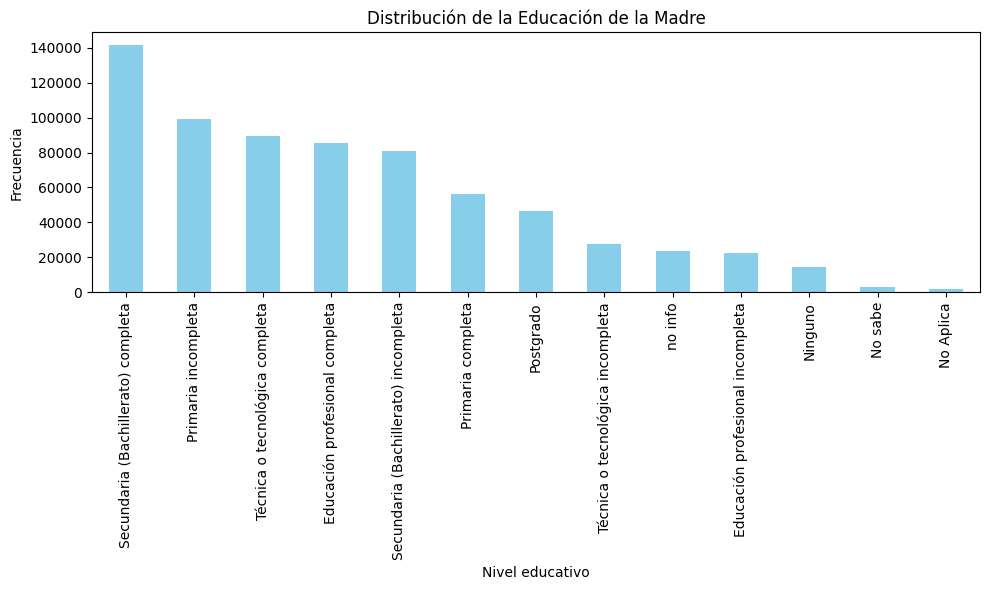

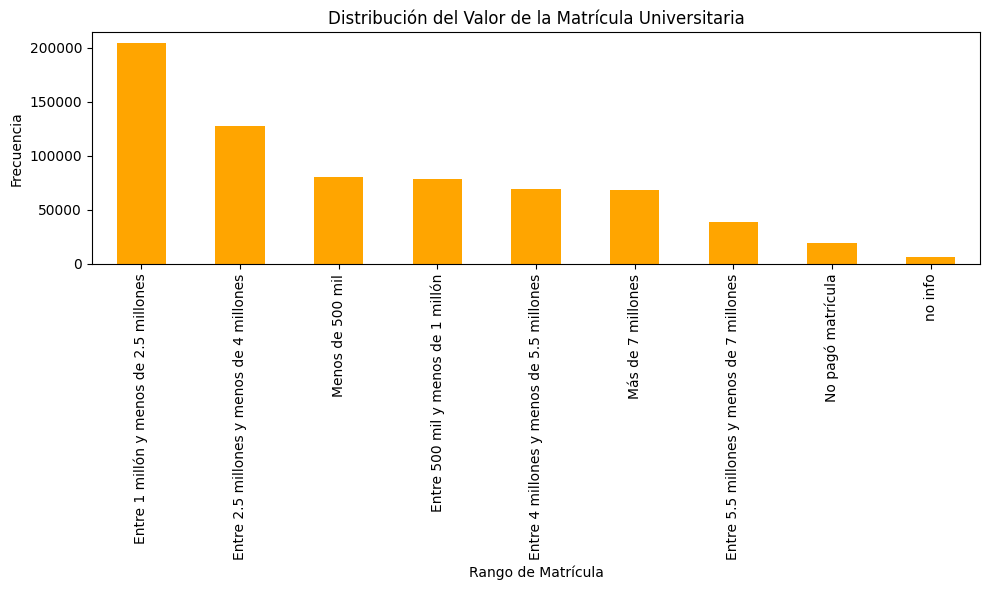

In [4]:
# GRÁFICA 1: Educación de la madre
plt.figure(figsize=(10, 6))
z.FAMI_EDUCACIONMADRE.value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribución de la Educación de la Madre')
plt.xlabel('Nivel educativo')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# GRÁFICA 2: Valor de matrícula
plt.figure(figsize=(10, 6))
z.ESTU_VALORMATRICULAUNIVERSIDAD.value_counts().plot(kind='bar', color='orange')
plt.title('Distribución del Valor de la Matrícula Universitaria')
plt.xlabel('Rango de Matrícula')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

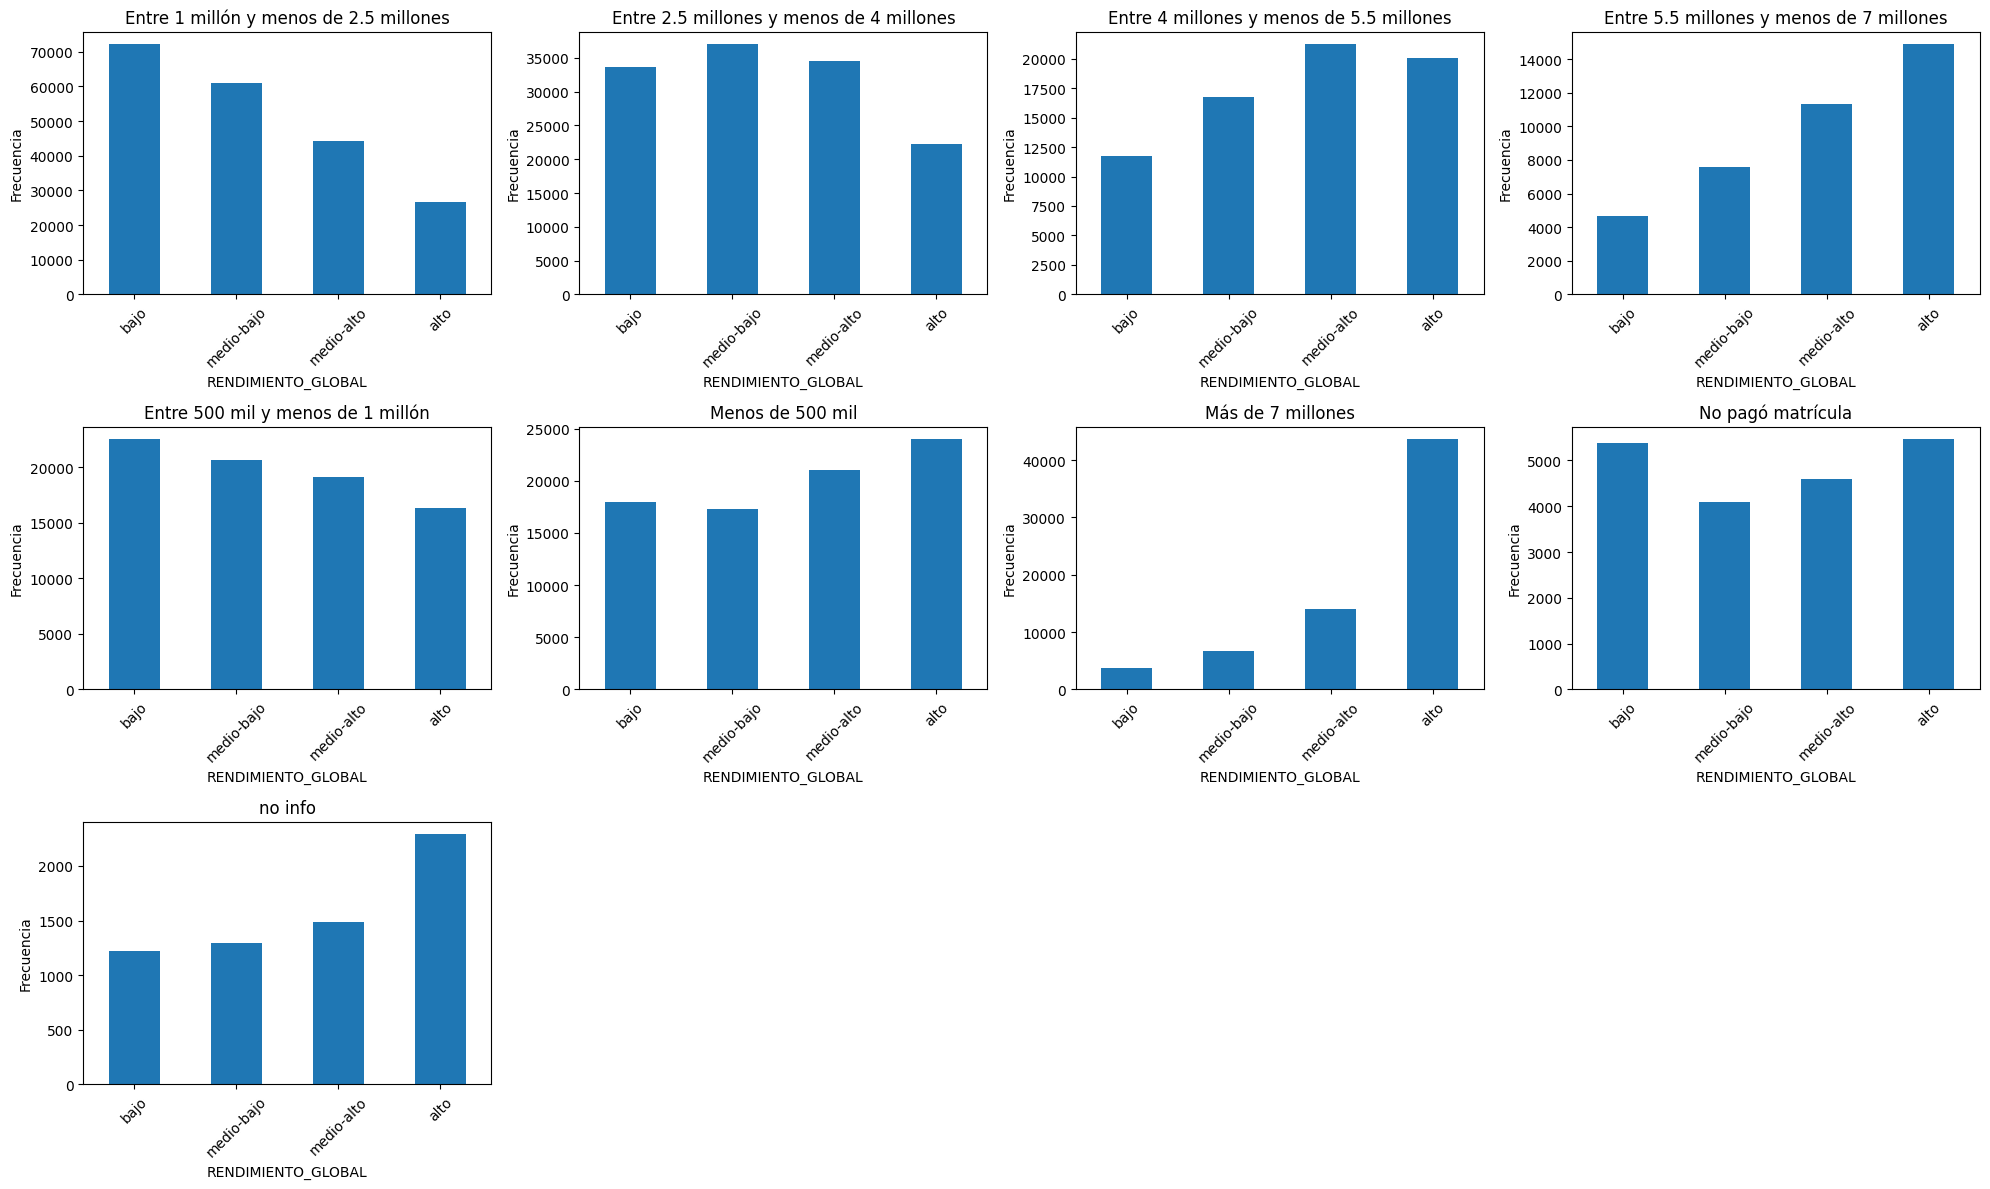

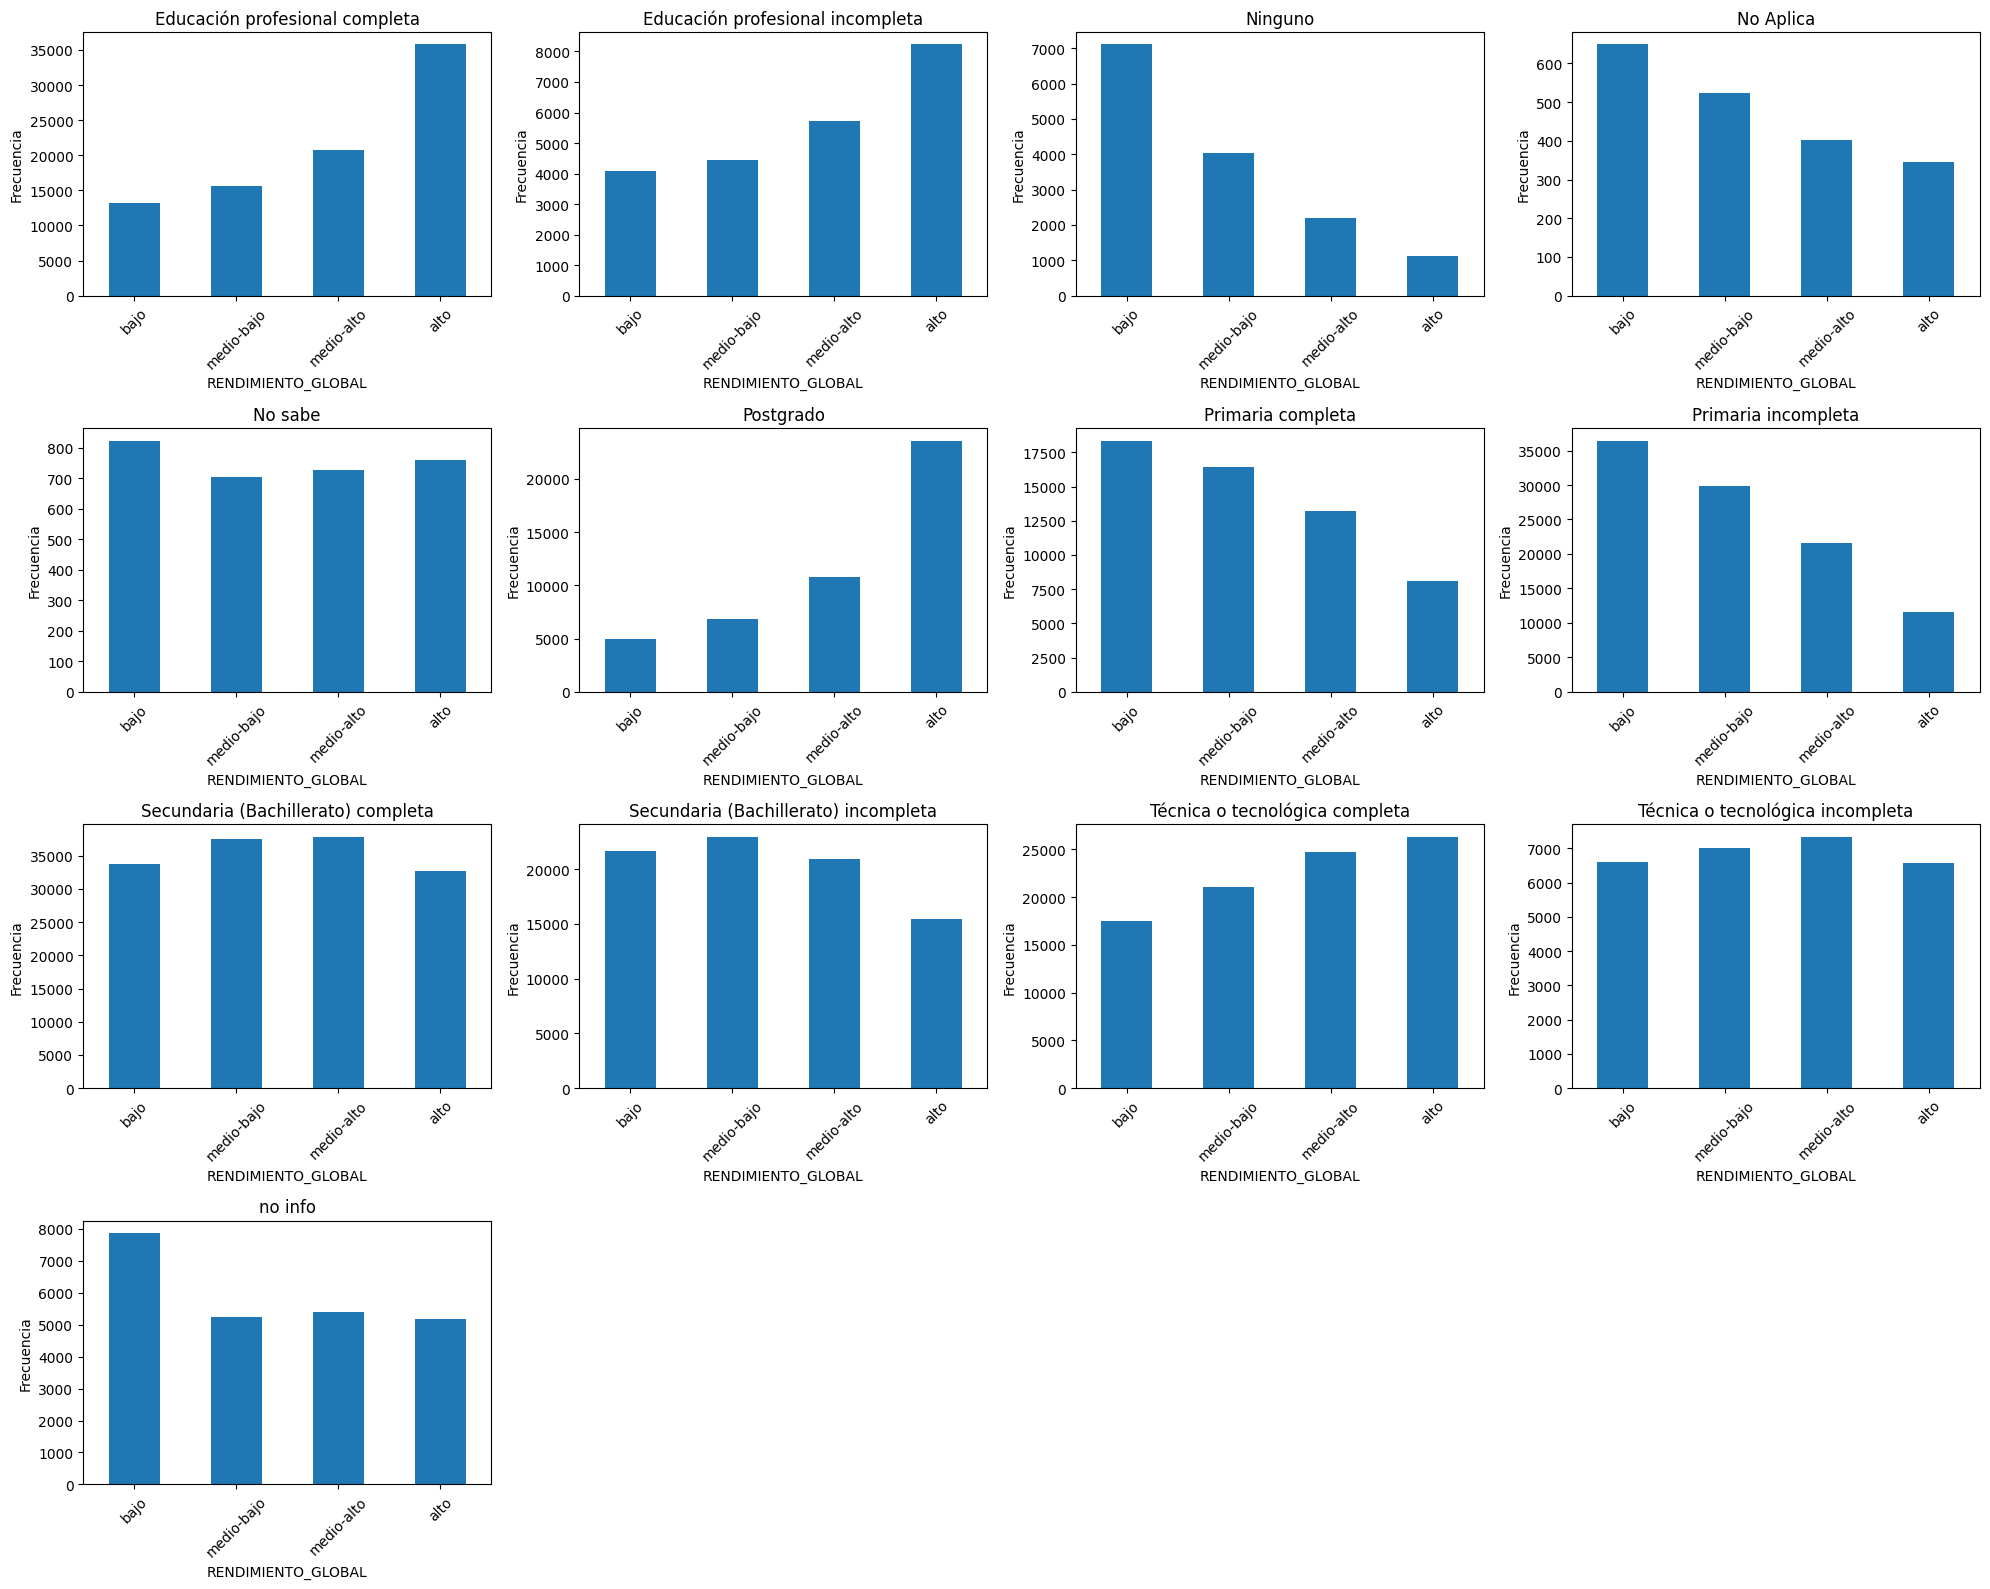

In [5]:
# GRÁFICAS MULTIPLES 1: MATRÍCULA vs RENDIMIENTO
categorias = sorted(z['ESTU_VALORMATRICULAUNIVERSIDAD'].dropna().unique())
n_cols = 4
n_rows = (len(categorias) + n_cols - 1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axs = axs.flatten()

for i, categoria in enumerate(categorias):
    subdf = z[z['ESTU_VALORMATRICULAUNIVERSIDAD'] == categoria]
    subdf['RENDIMIENTO_GLOBAL'].value_counts().reindex(
        ['bajo', 'medio-bajo', 'medio-alto', 'alto'], fill_value=0
    ).plot(kind='bar', ax=axs[i])
    axs[i].set_title(categoria)
    axs[i].set_ylabel('Frecuencia')
    axs[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

# GRÁFICAS MULTIPLES 2: EDUCACIÓN MADRE vs RENDIMIENTO

categorias = sorted(z['FAMI_EDUCACIONMADRE'].dropna().unique())
n_cols = 4
n_rows = (len(categorias) + n_cols - 1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axs = axs.flatten()

for i, categoria in enumerate(categorias):
    subdf = z[z['FAMI_EDUCACIONMADRE'] == categoria]
    subdf['RENDIMIENTO_GLOBAL'].value_counts().reindex(
        ['bajo', 'medio-bajo', 'medio-alto', 'alto'], fill_value=0
    ).plot(kind='bar', ax=axs[i])
    axs[i].set_title(categoria)
    axs[i].set_ylabel('Frecuencia')
    axs[i].tick_params(axis='x', rotation=45)

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

In [6]:
# CONVERTIR RANGO DE MATRÍCULA A VALORES CONTINUOS
cmap = {
    'Entre 1 millón y menos de 2.5 millones': 1.75,
    'Entre 2.5 millones y menos de 4 millones': 3.25,
    'Menos de 500 mil': 0.250,
    'Entre 500 mil y menos de 1 millón': 0.75,
    'Entre 4 millones y menos de 5.5 millones': 4.75,
    'Más de 7 millones': 7.75,
    'Entre 5.5 millones y menos de 7 millones': 6.25,
    'No pagó matrícula': 0,
    'no info': -1
}
z['ESTU_VALORMATRICULAUNIVERSIDAD'] = z['ESTU_VALORMATRICULAUNIVERSIDAD'].map(cmap)

print("Distribución de valores continuos de matrícula:\n")
print(z.ESTU_VALORMATRICULAUNIVERSIDAD.value_counts())

Distribución de valores continuos de matrícula:

ESTU_VALORMATRICULAUNIVERSIDAD
 1.75    204048
 3.25    127430
 0.25     80263
 0.75     78704
 4.75     69736
 7.75     68014
 6.25     38490
 0.00     19528
-1.00      6287
Name: count, dtype: int64


In [7]:
# ONE-HOT ENCODING DE 'FAMI_EDUCACIONMADRE'
x = z.FAMI_EDUCACIONMADRE.values
FAMI_EDUCACIONMADRE_vals = sorted(np.unique(x))
FAMI_EDUCACIONMADRE_onehot_vals = {
    val: np.eye(len(FAMI_EDUCACIONMADRE_vals))[i] for i, val in enumerate(FAMI_EDUCACIONMADRE_vals)
}

FAMI_EDUCACIONMADRE_onehot_enc = np.r_[
    [FAMI_EDUCACIONMADRE_onehot_vals[i] for i in z.FAMI_EDUCACIONMADRE]
]

FAMI_EDUCACIONMADRE_df = pd.DataFrame(
    FAMI_EDUCACIONMADRE_onehot_enc,
    columns=[f"FAMI_EDUCACIONMADRE__{v}" for v in FAMI_EDUCACIONMADRE_onehot_vals]
)

In [8]:
# CONCATENAR Y REMOVER COLUMNA ORIGINAL
z = pd.concat([FAMI_EDUCACIONMADRE_df, z], axis=1).drop('FAMI_EDUCACIONMADRE', axis=1)

# CONVERTIR VARIABLE OBJETIVO A NÚMEROS
y_col = 'RENDIMIENTO_GLOBAL'
rmap = {'alto': 3, 'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2}
z[y_col] = [rmap[i] for i in z[y_col]]

# RESULTADO FINAL
print("Shape final del dataframe:", z.shape)
print(z.head())


Shape final del dataframe: (692500, 15)
   FAMI_EDUCACIONMADRE__Educación profesional completa  \
0                                                0.0     
1                                                0.0     
2                                                0.0     
3                                                0.0     
4                                                0.0     

   FAMI_EDUCACIONMADRE__Educación profesional incompleta  \
0                                                0.0       
1                                                0.0       
2                                                0.0       
3                                                0.0       
4                                                0.0       

   FAMI_EDUCACIONMADRE__Ninguno  FAMI_EDUCACIONMADRE__No Aplica  \
0                           0.0                             0.0   
1                           0.0                             0.0   
2                           0.0                  